In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos,pi

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)
# testdata = torchvision.datasets.CIFAR10('./CIFAR10',train=False,download=True,transform=transforms.ToTensor())
# print(len(trainingdata),len(testdata))

Files already downloaded and verified


In [4]:
def load_data(is_train,aug,batch_size):
    dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
    return dataloader

batch_size = 256 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6


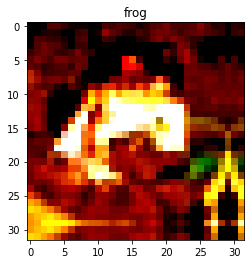

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
print(image.shape, label)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [6]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
#         out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
    return ResNet(BasicBlock, [3, 3, 3])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4335434


In [8]:
# X = torch.rand(size=(1, 3, 32, 32)).cuda()
# for layer in model1:
#   X = layer(X)
#   print(layer.__class__.__name__,'output shape:\t', X.shape)

In [9]:
def adjust_learning_rate(optimizer, current_epoch,max_epoch,lr_min=0,lr_max=0.1,warmup=True):
    warmup_epoch = 10 if warmup else 0
    if current_epoch < warmup_epoch:
        lr = lr_max * current_epoch / warmup_epoch
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [10]:
num_epochs = 500 # param
epoch_start = 0
path = 'resnet_aug_3block_sgd_warmup_consine.pt'

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()

lr = 0.8
lr_min=0.001
momentum = 0.9
nesterov = True
optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=momentum,nesterov=nesterov)



if os.path.exists(path):
    checkpoint = torch.load(path)
    print('Read model from checkpoint')
    model1.cuda().load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    Loss = checkpoint['Loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    train_accuracy_history = checkpoint['train_accuracy_history']
    test_accuracy_history = checkpoint['test_accuracy_history']
    print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs+1):
    timestart = time.time()

    train_loss = 0.0
    test_loss = 0.0
    train_accuracy = 0.0
    test_accuracy = 0.0

    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = model1.cuda()(images)
        fit = Loss(predicted_output,labels)
        fit.backward()
        adjust_learning_rate(optimizer=optimizer,current_epoch=epoch,max_epoch=num_epochs,lr_min=lr_min,lr_max=lr,warmup=True)
        optimizer.step()
        train_loss += fit.item()
        train_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = model1.cuda()(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    train_accu = train_accuracy/len(trainDataLoader)
    test_accu = test_accuracy/len(testDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accu)
    test_accuracy_history.append(test_accu)
    print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s, Cost %s s'%(epoch,
                                                                                                   train_loss,test_loss,
                                                                                                   train_accu,test_accu,
                                                                                                   time.time()-timestart))

    if epoch % 5 == 0 and epoch != 0:
        torch.save({'epoch':epoch,
          'model_state_dict':model1.cuda().state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'Loss':Loss,
          'train_loss_history':train_loss_history,
          'test_loss_history':test_loss_history,
          'train_accuracy_history':train_accuracy_history,
          'test_accuracy_history':test_accuracy_history},path)
        print('Model saved in epoch %s'%(epoch))

Epoch 1, Train loss 2.6113684353779774, Test loss 1.9181319743394851, Train accuracy 19.592235331632654, Test accuracy 29.755859375, Cost 76.93213677406311 s
Epoch 2, Train loss 1.7639922542231423, Test loss 1.557962667942047, Train accuracy 34.435188137755105, Test accuracy 42.5390625, Cost 75.9107677936554 s
Epoch 3, Train loss 1.4602618393849354, Test loss 1.3538518071174621, Train accuracy 46.45527742346939, Test accuracy 50.205078125, Cost 78.00854635238647 s
Epoch 4, Train loss 1.2375051719801766, Test loss 1.080451601743698, Train accuracy 55.54049744897959, Test accuracy 61.2890625, Cost 76.05040144920349 s
Epoch 5, Train loss 1.0417969828965712, Test loss 0.9873760357499123, Train accuracy 63.079958545918366, Test accuracy 64.775390625, Cost 73.2081127166748 s
Model saved in epoch 5
Epoch 6, Train loss 0.897520305246723, Test loss 0.8308227524161339, Train accuracy 68.37611609089132, Test accuracy 70.341796875, Cost 74.4862380027771 s
Epoch 7, Train loss 0.7921485304832458, Te

Epoch 52, Train loss 0.046851407147335766, Test loss 0.38969228863716127, Train accuracy 98.38647959183673, Test accuracy 91.552734375, Cost 73.0755832195282 s
Epoch 53, Train loss 0.04681458586484802, Test loss 0.39881554506719114, Train accuracy 98.35857780612245, Test accuracy 91.1328125, Cost 73.11171841621399 s
Epoch 54, Train loss 0.04450855157528149, Test loss 0.40978372991085055, Train accuracy 98.4438775510204, Test accuracy 91.162109375, Cost 73.08987307548523 s
Epoch 55, Train loss 0.04436362532385606, Test loss 0.420247208699584, Train accuracy 98.44308035714286, Test accuracy 90.791015625, Cost 77.03460264205933 s
Model saved in epoch 55
Epoch 56, Train loss 0.04012576074396469, Test loss 0.427964947745204, Train accuracy 98.56345663265306, Test accuracy 90.830078125, Cost 72.95914602279663 s
Epoch 57, Train loss 0.04430504396500788, Test loss 0.39514585472643377, Train accuracy 98.42713647959184, Test accuracy 91.40625, Cost 78.25055360794067 s
Epoch 58, Train loss 0.0379

Epoch 103, Train loss 0.01299909434972654, Test loss 0.4838934917002916, Train accuracy 99.5914381377551, Test accuracy 92.275390625, Cost 77.59821367263794 s
Epoch 104, Train loss 0.0117384318177106, Test loss 0.45948660746216774, Train accuracy 99.62292729591837, Test accuracy 92.421875, Cost 77.65867519378662 s
Epoch 105, Train loss 0.008762054896393163, Test loss 0.4506728298962116, Train accuracy 99.71659757653062, Test accuracy 92.5, Cost 75.74789714813232 s
Model saved in epoch 105
Epoch 106, Train loss 0.010946219583274797, Test loss 0.45215365290641785, Train accuracy 99.6273118622449, Test accuracy 92.12890625, Cost 73.93587493896484 s
Epoch 107, Train loss 0.008241089197549534, Test loss 0.496920345723629, Train accuracy 99.69706632653062, Test accuracy 92.12890625, Cost 74.02866983413696 s
Epoch 108, Train loss 0.011657936388343972, Test loss 0.4709828309714794, Train accuracy 99.59263392857143, Test accuracy 92.2265625, Cost 78.25084066390991 s
Epoch 109, Train loss 0.0106

Epoch 153, Train loss 0.0042048249388244585, Test loss 0.5454222068190575, Train accuracy 99.85052614795919, Test accuracy 92.24609375, Cost 73.89837098121643 s
Epoch 154, Train loss 0.003936996468967534, Test loss 0.5230246551334858, Train accuracy 99.85251913265306, Test accuracy 92.5390625, Cost 78.0650565624237 s
Epoch 155, Train loss 0.003834838101525116, Test loss 0.499076659232378, Train accuracy 99.86846301020408, Test accuracy 92.587890625, Cost 74.21603631973267 s
Model saved in epoch 155
Epoch 156, Train loss 0.004919165913058666, Test loss 0.5029964644461871, Train accuracy 99.82661033163265, Test accuracy 92.7734375, Cost 74.71437072753906 s
Epoch 157, Train loss 0.003384122667349792, Test loss 0.5255127504467965, Train accuracy 99.89835778061224, Test accuracy 92.63671875, Cost 75.4385576248169 s
Epoch 158, Train loss 0.004257411848811898, Test loss 0.509187800809741, Train accuracy 99.86647002551021, Test accuracy 92.51953125, Cost 74.27165818214417 s
Epoch 159, Train lo

Epoch 203, Train loss 0.00136928649027252, Test loss 0.5386601012200117, Train accuracy 99.95216836734694, Test accuracy 92.98828125, Cost 104.88220071792603 s
Epoch 204, Train loss 0.0017464127161205471, Test loss 0.5785231649875641, Train accuracy 99.95416135204081, Test accuracy 92.55859375, Cost 106.10371518135071 s
Epoch 205, Train loss 0.001105666533330155, Test loss 0.5689601708203554, Train accuracy 99.96014030612245, Test accuracy 92.861328125, Cost 102.96359038352966 s
Model saved in epoch 205
Epoch 206, Train loss 0.0011392870213409404, Test loss 0.5575924724340439, Train accuracy 99.95814732142857, Test accuracy 92.958984375, Cost 106.08299160003662 s
Epoch 207, Train loss 0.0007927950660322661, Test loss 0.5655528493225574, Train accuracy 99.97209821428571, Test accuracy 92.890625, Cost 104.10787749290466 s
Epoch 208, Train loss 0.001844447645225955, Test loss 0.5585588704794645, Train accuracy 99.94419642857143, Test accuracy 92.705078125, Cost 103.01934719085693 s
Epoch 

Epoch 253, Train loss 0.00019464386025882336, Test loss 0.5576738405972719, Train accuracy 99.99601403061224, Test accuracy 93.2421875, Cost 107.39180850982666 s
Epoch 254, Train loss 0.0002733066902450497, Test loss 0.5564858686178923, Train accuracy 99.99202806122449, Test accuracy 93.30078125, Cost 103.67284798622131 s
Epoch 255, Train loss 0.0002922028575346294, Test loss 0.56854924634099, Train accuracy 99.98604910714286, Test accuracy 93.26171875, Cost 105.32779788970947 s
Model saved in epoch 255
Epoch 256, Train loss 0.0001741725318036246, Test loss 0.5743067041039467, Train accuracy 99.99601403061224, Test accuracy 93.3203125, Cost 107.16675043106079 s
Epoch 257, Train loss 0.0002350581301886116, Test loss 0.572936725616455, Train accuracy 99.99402104591837, Test accuracy 93.359375, Cost 106.25709176063538 s
Epoch 258, Train loss 0.0003240839140670692, Test loss 0.5589260507375002, Train accuracy 99.98804209183673, Test accuracy 93.3203125, Cost 105.29834246635437 s
Epoch 259,

Epoch 304, Train loss 6.470675408864128e-05, Test loss 0.5775088399648667, Train accuracy 99.99800701530613, Test accuracy 93.193359375, Cost 106.15196895599365 s
Epoch 305, Train loss 0.00010363399882484576, Test loss 0.575618152692914, Train accuracy 100.0, Test accuracy 93.134765625, Cost 106.85362958908081 s
Model saved in epoch 305
Epoch 306, Train loss 5.189922556048563e-05, Test loss 0.573993007466197, Train accuracy 100.0, Test accuracy 93.232421875, Cost 106.12869787216187 s
Epoch 307, Train loss 3.0234615530438142e-05, Test loss 0.5743509065359831, Train accuracy 100.0, Test accuracy 93.271484375, Cost 105.19574785232544 s
Epoch 308, Train loss 0.00014520124672488384, Test loss 0.5787982467561961, Train accuracy 99.99601403061224, Test accuracy 93.26171875, Cost 106.54088377952576 s
Epoch 309, Train loss 9.20734032822815e-05, Test loss 0.5781725786626339, Train accuracy 99.99800701530613, Test accuracy 93.359375, Cost 104.95211172103882 s
Epoch 310, Train loss 3.7905460091019

Epoch 356, Train loss 1.794668045404796e-05, Test loss 0.5797656673938036, Train accuracy 100.0, Test accuracy 93.3203125, Cost 106.6797297000885 s
Epoch 357, Train loss 4.4317431777721354e-05, Test loss 0.579097131639719, Train accuracy 99.99800701530613, Test accuracy 93.369140625, Cost 106.18866491317749 s
Epoch 358, Train loss 2.4889978658262867e-05, Test loss 0.5796777904033661, Train accuracy 100.0, Test accuracy 93.33984375, Cost 107.1189374923706 s
Epoch 359, Train loss 4.7138959899794425e-05, Test loss 0.5784480422735214, Train accuracy 99.99601403061224, Test accuracy 93.3203125, Cost 108.06895518302917 s
Epoch 360, Train loss 2.8099358879689255e-05, Test loss 0.5791107177734375, Train accuracy 100.0, Test accuracy 93.3203125, Cost 106.99604964256287 s
Model saved in epoch 360
Epoch 361, Train loss 2.677759947941899e-05, Test loss 0.5795267757028342, Train accuracy 100.0, Test accuracy 93.30078125, Cost 105.50337815284729 s
Epoch 362, Train loss 2.34781809488123e-05, Test los

Epoch 409, Train loss 1.989195578820459e-05, Test loss 0.5841676954180002, Train accuracy 100.0, Test accuracy 93.466796875, Cost 73.05993175506592 s
Epoch 410, Train loss 2.3736877364575374e-05, Test loss 0.5848733965307474, Train accuracy 100.0, Test accuracy 93.49609375, Cost 73.10660290718079 s
Model saved in epoch 410
Epoch 411, Train loss 3.487553228913904e-05, Test loss 0.5862936560064554, Train accuracy 99.99800701530613, Test accuracy 93.4765625, Cost 73.3897454738617 s
Epoch 412, Train loss 2.8795586667890965e-05, Test loss 0.5863434262573719, Train accuracy 100.0, Test accuracy 93.486328125, Cost 73.91532731056213 s
Epoch 413, Train loss 1.9727797419020832e-05, Test loss 0.5863670703023672, Train accuracy 100.0, Test accuracy 93.45703125, Cost 73.81565546989441 s
Epoch 414, Train loss 1.3829125712345645e-05, Test loss 0.5862539298832417, Train accuracy 100.0, Test accuracy 93.45703125, Cost 74.0964674949646 s
Epoch 415, Train loss 2.6492865938438146e-05, Test loss 0.58607341

Epoch 462, Train loss 1.325794052429118e-05, Test loss 0.5869820933789015, Train accuracy 100.0, Test accuracy 93.408203125, Cost 78.38200354576111 s
Epoch 463, Train loss 1.2697354626625407e-05, Test loss 0.5869838912039995, Train accuracy 100.0, Test accuracy 93.408203125, Cost 75.73215913772583 s
Epoch 464, Train loss 1.0460564207871017e-05, Test loss 0.5870340719819069, Train accuracy 100.0, Test accuracy 93.408203125, Cost 74.62927865982056 s
Epoch 465, Train loss 1.20900229890186e-05, Test loss 0.5870556265115738, Train accuracy 100.0, Test accuracy 93.408203125, Cost 74.32495927810669 s
Model saved in epoch 465
Epoch 466, Train loss 3.385040317585971e-05, Test loss 0.5870192088186741, Train accuracy 100.0, Test accuracy 93.408203125, Cost 75.74429821968079 s
Epoch 467, Train loss 1.1561016646813248e-05, Test loss 0.5870306458324194, Train accuracy 100.0, Test accuracy 93.408203125, Cost 74.52513456344604 s
Epoch 468, Train loss 2.46272466835289e-05, Test loss 0.5870745249092579,

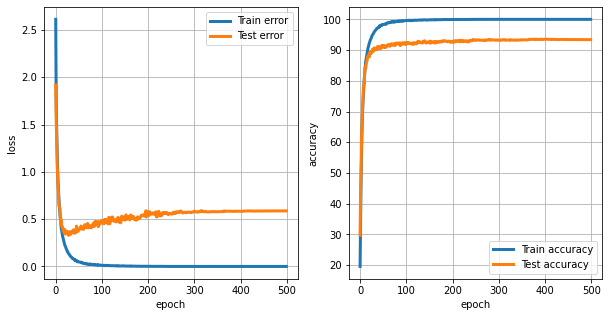

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [12]:
print('Accuracy:',sum(test_accuracy_history[-5:])/5)

Accuracy: 93.3984375
